# Pick this policy that has small test_loss and large sum_reward from 0107

In [1]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [2]:
def set_up_rl_agent(sess, dirname):
    with open(os.path.join(dirname, 'hyperparams.log'), 'r') as file:
        hparams = json.load(file)
        policy_hyparams = hparams['rl']

    with open(os.path.join(dirname, 'results.json'), 'r') as file:
        training_results = json.load(file)

    # set up trained policy ----------------
    with tf.variable_scope('dqn', reuse=tf.AUTO_REUSE):
        dqn = SequencialDuelingDQN(**policy_hyparams)

    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='dqn'))
    saver.restore(sess, os.path.join(dirname, 'model-%d' % training_results['best_model_idx']))

    return dqn

In [3]:
# Low test loss, good sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-64-lr-0.01-reg-0.01-0.5-s-256-5000-i-50-500-3-1/'
# 1st sum_reward
policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-128-lr-0.01-reg-0.0-0.5-s-256-5000-i-50-500-3-1/'
# 0 action cost for 0108
# policy_dir = '../models/dqn_mimic-0108_roc_curve-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-128-lr-0.0001-reg-0.001-0.7-s-512-5000-i-50-500-3-1/'

cache_dir = '../RL_exp_cache/1128-30mins-24hrs-20order-rnn-neg_sampled/'

In [4]:
# Setup the DQN
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)

dqn = set_up_rl_agent(sess, policy_dir)

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-128

In [5]:
# Set up per-time loader
mimic_exp = MIMIC_cache_discretized_exp_env_v3(cache_dir=cache_dir)
test_loader = mimic_exp.gen_experience(sess=sess, filename='test_per_time_env', batch_size=512, shuffle=False)

In [6]:
all_keys = ['seq_actions', 'patient_inds', 'mortality', 'the_steps', 'cur_actions']
result = {k: [] for k in all_keys}
for idx, exp in enumerate(test_loader):
    exp['seq_actions'] = dqn.get_best_sequential_actions(sess=sess, cur_state=exp['cur_state'])
    for k in all_keys:
        result[k].append(exp[k])

In [7]:
for k in all_keys:
    result[k] = np.concatenate(result[k], axis=0)
    if result[k].ndim > 1:
        result[k] = result[k].tolist()

In [8]:
df = pd.DataFrame(result)

In [9]:
df.shape

(272575, 5)

In [10]:
np.vstack(df[df.patient_inds == 1].seq_actions.values)[0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 1.])

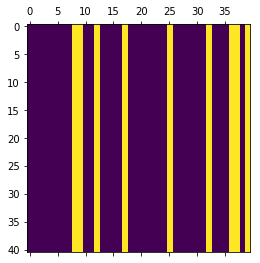

In [11]:
plt.matshow(np.vstack(df[df.patient_inds == 1].seq_actions.values))

In [12]:
mortality_pat_inds = df[df.mortality == 1].patient_inds.unique()
alive_pat_inds = df[df.mortality == 0].patient_inds.unique()

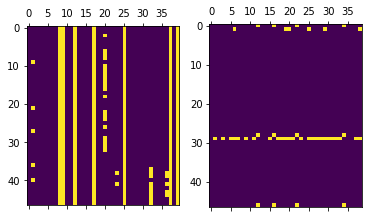

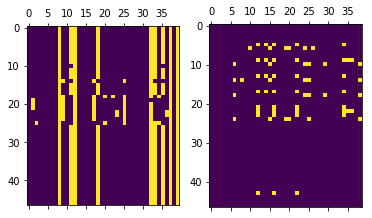

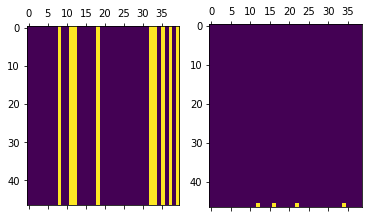

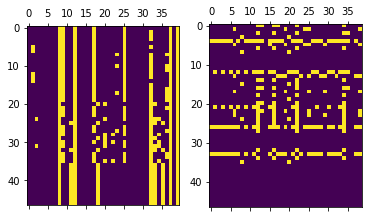

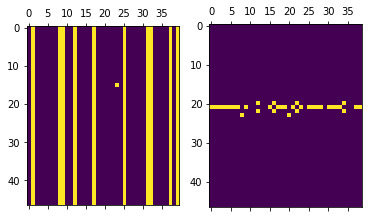

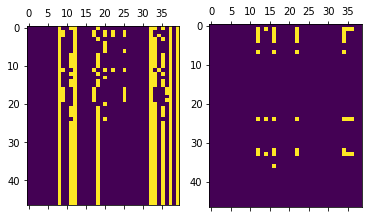

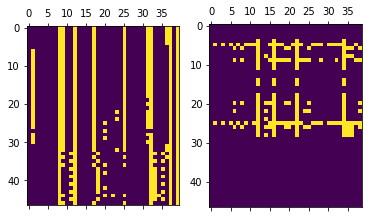

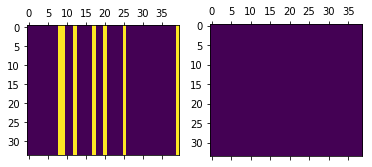

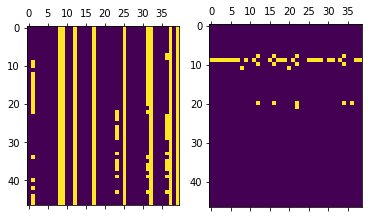

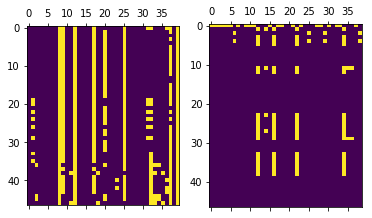

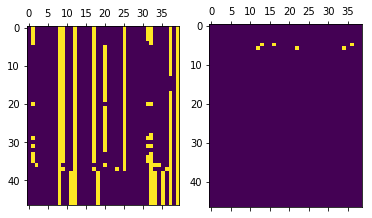

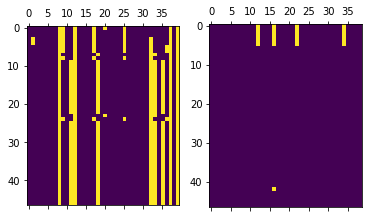

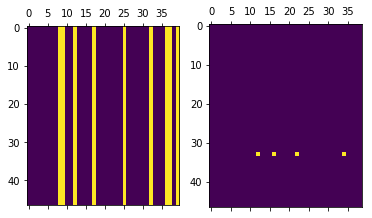

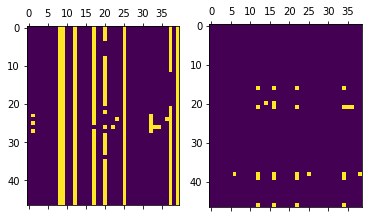

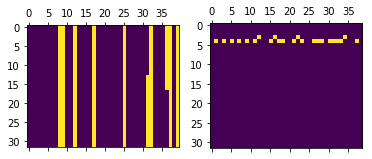

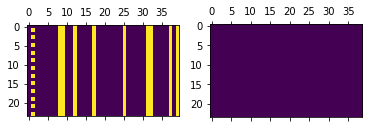

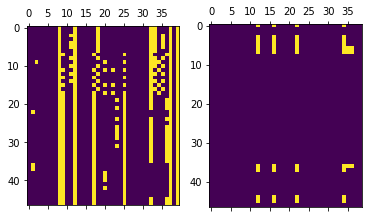

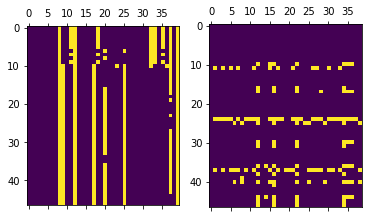

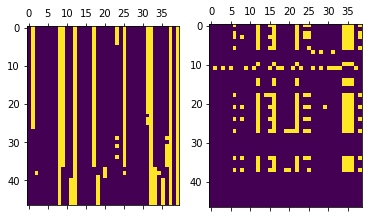

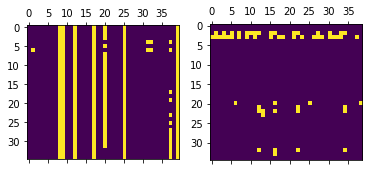

In [17]:
for i in range(20):
    fig, ax = plt.subplots(1, 2)
    ax[0].matshow(np.vstack(df[df.patient_inds == mortality_pat_inds[i]].seq_actions.values))
    the_plot = ax[1].matshow(np.vstack(df[df.patient_inds == mortality_pat_inds[i]].cur_actions.values))
#     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

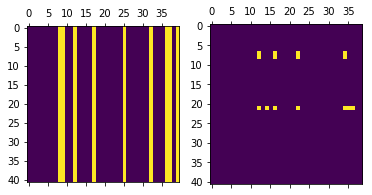

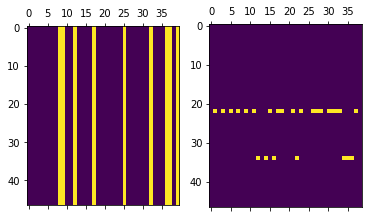

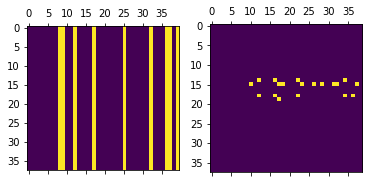

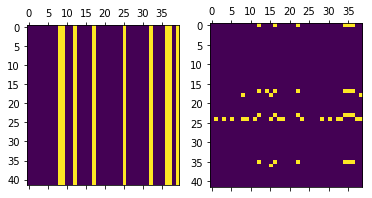

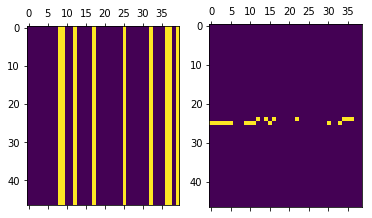

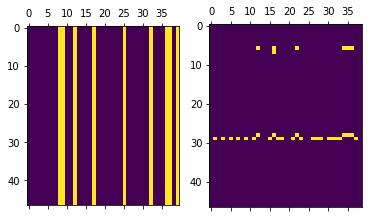

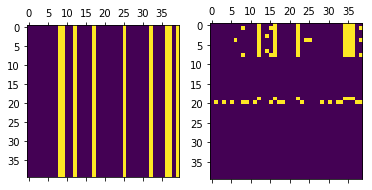

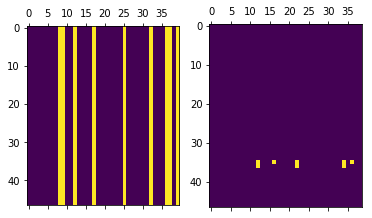

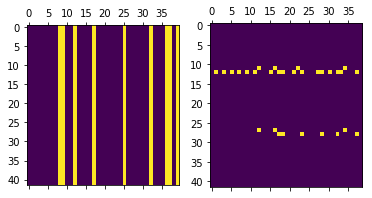

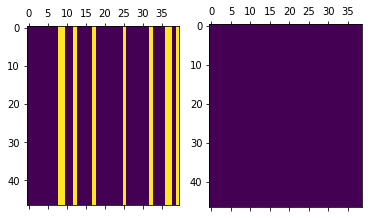

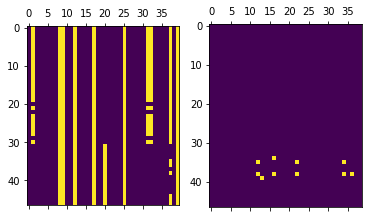

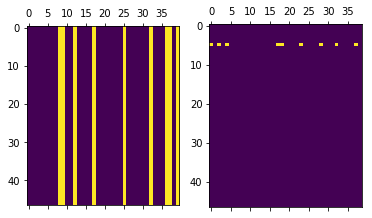

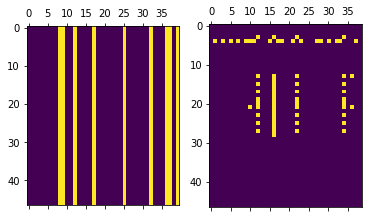

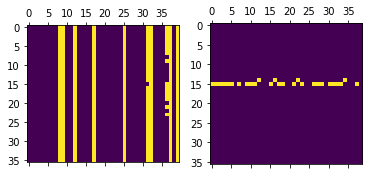

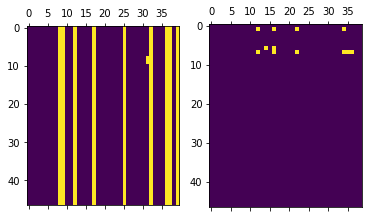

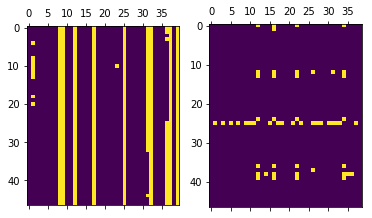

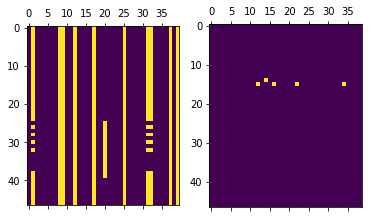

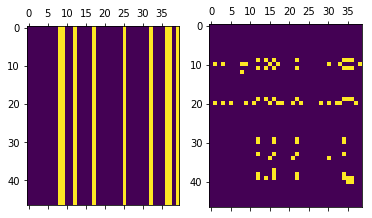

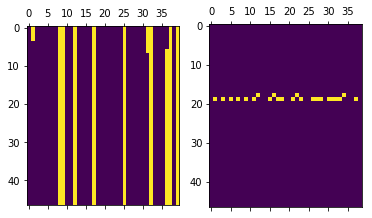

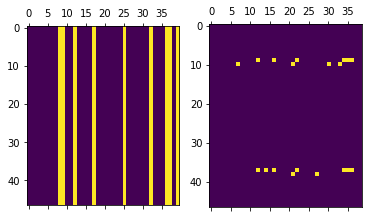

In [18]:
for i in range(20):
    fig, ax = plt.subplots(1, 2)
    ax[0].matshow(np.vstack(df[df.patient_inds == alive_pat_inds[i]].seq_actions.values))
    the_plot = ax[1].matshow(np.vstack(df[df.patient_inds == alive_pat_inds[i]].cur_actions.values))
#     plt.colorbar(the_plot, ax=ax[1])
    plt.show()